In [0]:
import tensorflow as tf
#import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
# tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout,Input
from tensorflow.keras.optimizers import Adam, RMSprop
import random
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
## Preprocessing

X_train = X_train.reshape(X_train.shape[0], 
                          np.prod(X_train[0].shape))
X_test = X_test.reshape(X_test.shape[0], 
                          np.prod(X_test[0].shape))

# Normalizer dtype

X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

In [0]:
# So chieu cua noise vector input ban dau
z_dim = 100

In [0]:
# Optimizer

adam = Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [0]:
# Generator Model
g = Sequential()

g.add(Dense(units = 256, input_dim = z_dim, activation = LeakyReLU(0.2)))
g.add(Dense(units = 512, activation = LeakyReLU(0.2)))
g.add(Dense(units = 1024, activation = LeakyReLU(0.2)))
g.add(Dense(units = 784, activation = 'sigmoid'))

g.compile(loss = 'binary_crossentropy', optimizer = adam, 
          metrics = ['accuracy'])

g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               803600    
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_________________________________________________________________


In [0]:
## Discriminator Model

d = Sequential()

d.add(Dense(1024, input_dim = 784, activation = LeakyReLU(0.2)))
d.add(Dropout(0.25))
d.add(Dense(512, activation = LeakyReLU(0.2)))
d.add(Dropout(0.25))
d.add(Dense(256, activation = LeakyReLU(0.2)))
d.add(Dropout(0.25))
d.add(Dense(1, activation = 'sigmoid'))

d.compile(loss= 'binary_crossentropy', 
          optimizer = adam,
          metrics = ['accuracy'])

d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [0]:
d.trainable = False

inputs = Input(shape = (z_dim, ))

g_output = g(inputs)
output = d(g_output)

gan = Model(inputs, output)
gan.compile(loss = 'binary_crossentropy', 
            optimizer = adam, 
            metrics = ['accuracy'])

gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
# Draw loss function
def plot_loss(losses):
    d_loss = [v[0] for v in losses['D']]
    g_loss = [v[0] for v in losses['G']]

    plt.figure(fig_size = (10,10))
    plt.plot(d_loss, label = 'Disc. Loss')
    plt.plot(g_loss, label = 'Gen. Loss') 

    plt.xlabel('Epochs')
    plt.ylable('Loss')
    plt.legend()
    plt.show()

# Draw sample from Generator
def plot_generated(n_ex = 10, dim = (1,10), figsize= (8,4)):
    noise = np.random.normal(0,1,size= (n_ex, z_dim))
    generated_image = g.predict(noise)
    generated_image = generated_image.reshape(n_ex, 28, 28)

    plt.figure()
    for i in range(generated_image.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_image[i],
                   interpolation='nearest',
                   cmap = 'gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
        

In [0]:
# Save loss and accuracy values

losses = {'D': [], 'G': []}

In [0]:
from tqdm import tqdm_notebook as notebook

In [0]:
def train(epochs = 1, plt_frq = 1, BATCH_SIZE = 128):
    batchCount = int(X_train.shape[0]/ BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    for e in notebook(range(1, epochs + 1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, "Epoch %d" % e, '-'*15)
        for _ in range(batchCount):
            # Lay ngau nhien anh tu MNIST dataset (real)
            image_batch = X_train[np.random.randint(0,X_train.shape[0], size = BATCH_SIZE)]
            # Noise random vector input
            noise = np.random.normal(0,1,size = (BATCH_SIZE, z_dim))
            # Generator sinh ra tu and noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9

            # Train Discriminator
            d.trainable = True
            d_loss = d.train_on_batch(X,y)

            # Train Generator
            noise = np.random.normal(0,1,size = (BATCH_SIZE, z_dim))
            ## Khi train generator gan label bang 1 de lua Discriminator
            y2 = np.ones(BATCH_SIZE)
            ## Khi train generator khong cap nhat he so cua Disciminator
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
        
        #Save loss function
        losses['D'].append(d_loss)
        losses['G'].append(g_loss)

        # Vẽ các số được sinh ra để kiểm tra kết quả
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 300
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


--------------- Epoch 1 ---------------


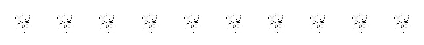

In [0]:
train(epochs=300, plt_frq=20, BATCH_SIZE=128)